# <span style="color:#FF5733">**<u>CrackSpread Strategy</u>**</span>

The objective of this code is to implement the crackspread strategy using the VectorBT algorithmic trading framework. While this code does not provide a direct or definitive result for the optimal parameters of the strategy, it serves as a template for optimization and robustness testing. The final choice of parameters depends on the trader's own perspective, approach, and strategy. This code is intended as a tool to facilitate the exploration and refinement of trading strategies, not to prescribe specific parameter sets.


## Strategy Overview

This strategy focuses on identifying trading opportunities based on the **crackspread**, which represents the gross margin of refineries. The crackspread is calculated as the difference between the prices of three barrels of crude oil, two barrels of gasoline, and one barrel of heating oil. While this example uses these refined products, the spread can be calculated with other combinations depending on the trader's approach.

The strategy works as follows:
1. **Crackspread Calculation**: We first calculate the crackspread, representing the refinery's margin.
2. **Percentile Calculation**: Using a rolling window, we compute the percentiles for both the crackspread and the stock price of a specific refinery.
3. **Divergence Detection**: The divergence is calculated by subtracting the refinery stock's percentile from the crackspread's percentile.
4. **Z-Score Normalization**: These divergence values are normalized using z-scores to identify significant deviations.

The core idea of the strategy is to find divergences between the refinery margin (crackspread) and the stock price of a refinery. The goal is to detect market inefficiencies where the refinery margin increases, but the refinery stock price has yet to adjust accordingly, providing a potential opportunity for profit.


# <span style="color:#FF5733">**<u>1. CrackSpread Strategy Optimization</u>**</span>
The first section of this notebook focuses on optimizing the parameters of the crackspread strategy. Specifically, it involves identifying the optimal threshold pairs for entering and exiting positions. The goal is to determine the most effective parameter combinations that enhance the performance of the strategy.

## Libraries Used

This project utilizes a number of key Python libraries to implement, optimize, and visualize the crackspread trading strategy:

- **Pandas**: For efficient data handling and manipulation.
- **VectorBT**: The core framework for backtesting and optimizing the strategy in an algorithmic trading context.
- **NumPy**: Provides support for fast numerical computations and array manipulations.
- **Itertools (product)**: Used for generating combinations of different strategy parameters for optimization.
- **SciPy (stats)**: Offers statistical tools like z-score calculations, which are integral to the strategy.
- **Matplotlib**: A plotting library to visualize performance and other relevant data.

Each of these libraries plays a specific role in constructing the trading strategy, from data handling to optimization and visualization.


In [1]:
import pandas as pd 
import vectorbt as vbt 
import numpy as np 
from itertools import product
from vectorbt.indicators import IndicatorFactory
import scipy.stats as stats
import matplotlib.pyplot as plt

## Data Extraction

In [2]:
# Define parameters and data for the crackspread strategy
window = 21  # Rolling window size
thresh = 2  # Z-score threshold for divergences
refiner_symbol = "PSX"  # Refinery stock symbol


# Download data from Yahoo Finance
start = pd.Timestamp("2010")
end = pd.Timestamp("2023-12-31")
data = vbt.YFData.download(
    ["CL=F", "RB=F", "HO=F", refiner_symbol], start=start, end=end, missing_index="drop"
)

# Extract closing prices
cl = data.get("Close")["CL=F"]
rb = data.get("Close")["RB=F"]
ho = data.get("Close")["HO=F"]
refiner = data.get("Close")[refiner_symbol]

/Applications/anaconda3/lib/python3.8/site-packages/vectorbt/data/base.py:527: UserWarning: Symbols have mismatching index. Dropping missing data points.
  data = cls.align_index(data, missing=missing_index)


In [3]:
# Ensure all series have the same length and indices
if len(cl) != len(rb) or len(rb) != len(ho) or len(ho) != len(refiner):
    print("series have different lengths")  # Check if any series have different lengths
elif not (cl.index.equals(rb.index) and rb.index.equals(ho.index) and ho.index.equals(refiner.index)):
    print("series have different indices")  # Check if any series have different indices
else:
    print("all series have the same length and index")  # All checks passed


all series have the same length and index


## Raw Data Visualization

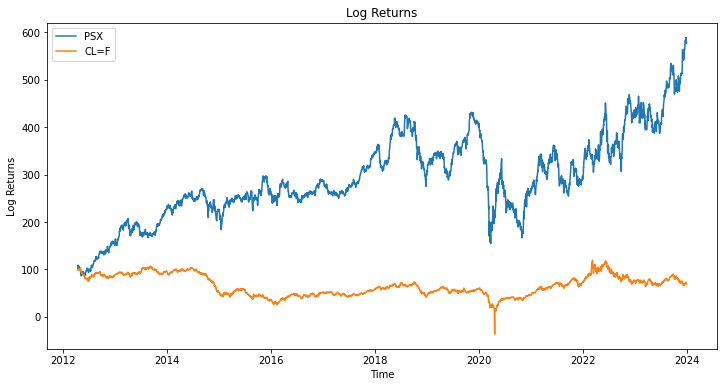

In [4]:
normalized_refiner_price = refiner / refiner.iloc[0] * 100  # Normalize refiner stock prices
normalized_crude_price = cl / cl.iloc[0] * 100  # Normalize crude oil prices

plt.figure(figsize=(12, 6))
plt.plot(normalized_refiner_price, label=refiner_symbol)
plt.plot(normalized_crude_price, label="CL=F")
plt.legend()
plt.title("Log Returns")
plt.xlabel("Time")
plt.ylabel("Log Returns")
plt.show()


/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


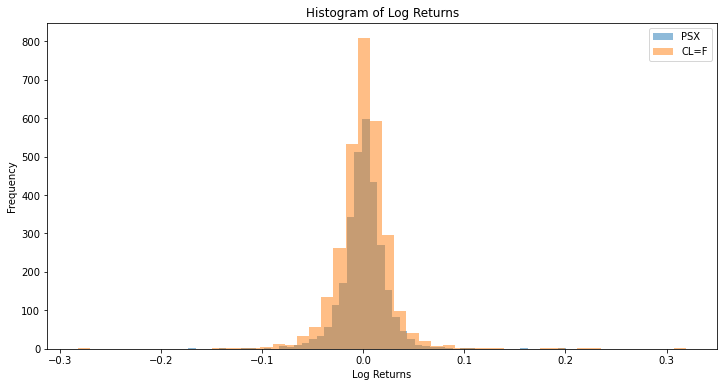

In [5]:
refiner_log_returns = np.log(refiner / refiner.shift(1))  # Calculate log returns for refiner stock
crude_log_returns = np.log(cl / cl.shift(1))  # Calculate log returns for crude oil

# Create the figure with the specified size
plt.figure(figsize=(12, 6))

# Plot the histogram for refiner log returns
plt.hist(refiner_log_returns.dropna(), bins=50, alpha=0.5, label=refiner_symbol)

# Plot the histogram for crude oil log returns
plt.hist(crude_log_returns.dropna(), bins=50, alpha=0.5, label="CL=F")

# Add title and labels
plt.title("Histogram of Log Returns")
plt.xlabel("Log Returns")
plt.ylabel("Frequency")

# Add legend
plt.legend()

# Show the plot
plt.show()


## Data Transformation

In [6]:
# Calculate the crack spread
rb *= 42  # Convert gasoline prices to barrels
ho *= 42  # Convert heating oil prices to barrels
crack_spread = (2 * rb + ho - 3 * cl) / 3  # Crack spread calculation

# Normalize and find divergence between the crack spread and refiner prices
crack_spread_rank = crack_spread.rolling(window).rank(pct=True)  # Percentile rank of crack spread
refiner_rank = refiner.rolling(window).rank(pct=True)  # Percentile rank of refiner prices
rank_spread = refiner_rank - crack_spread_rank  # Difference in ranks
roll = rank_spread.rolling(window)  # Rolling window for rank spread
zscore = (rank_spread - roll.mean()) / roll.std()  # Z-score calculation

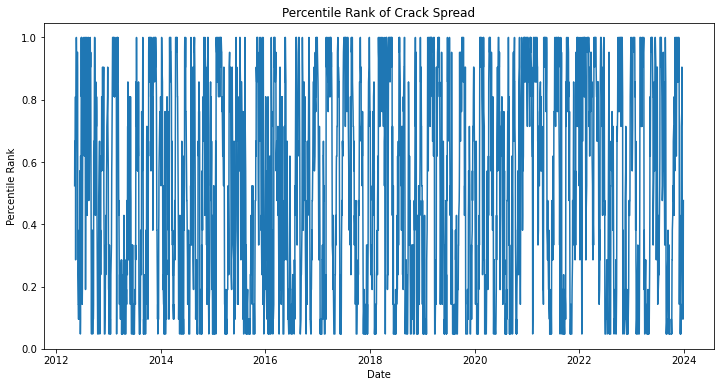

In [7]:
# Calculate the percentile rank of crack spread
crack_spread_rank = crack_spread.rolling(window).rank(pct=True)

# Create the figure with the specified size
plt.figure(figsize=(12, 6))

# Plot the percentile rank of crack spread
plt.plot(crack_spread_rank)

# Add title and labels
plt.title("Percentile Rank of Crack Spread")
plt.xlabel("Date")
plt.ylabel("Percentile Rank")

# Show the plot
plt.show()

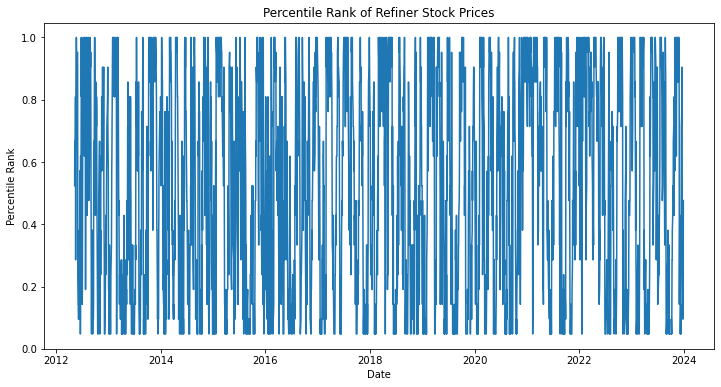

In [8]:
refiner_rank = refiner.rolling(window).rank(pct=True)  # Percentile rank of refiner prices

# Create the figure with the specified size
plt.figure(figsize=(12, 6))

# Plot the percentile rank of crack spread
plt.plot(crack_spread_rank)

# Add title and labels
plt.title("Percentile Rank of Refiner Stock Prices")
plt.xlabel("Date")
plt.ylabel("Percentile Rank")

# Show the plot
plt.show()

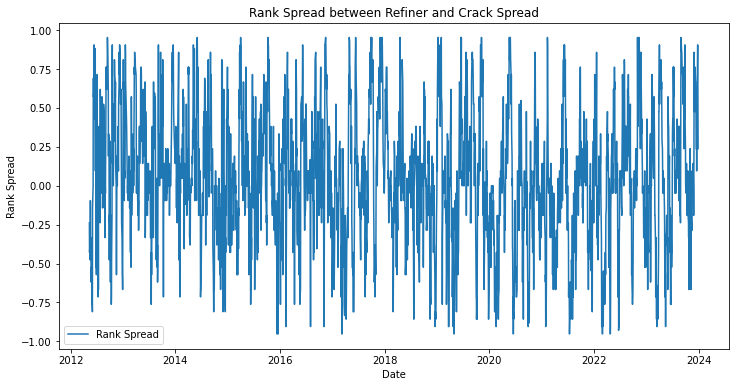

In [9]:
# Calculate the difference in ranks between refiner and crack spread
rank_spread = refiner_rank - crack_spread_rank  # Difference in ranks

# Create the figure with the specified size
plt.figure(figsize=(12, 6))

# Plot the rank spread
plt.plot(rank_spread, label='Rank Spread')

# Add title and labels
plt.title("Rank Spread between Refiner and Crack Spread")
plt.xlabel("Date")
plt.ylabel("Rank Spread")

# Add legend
plt.legend()

# Show the plot
plt.show()

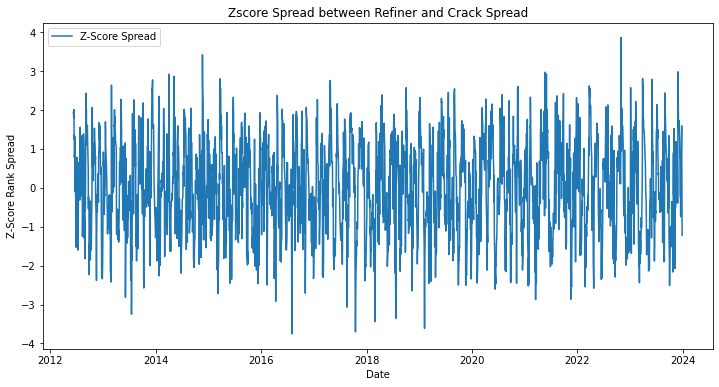

In [10]:
roll = rank_spread.rolling(window)  # Rolling window for rank spread
zscore = (rank_spread - roll.mean()) / roll.std()  # Z-score calculation

# Create the figure with the specified size
plt.figure(figsize=(12, 6))

# Plot the rank spread
plt.plot(zscore, label='Z-Score Spread')

# Add title and labels
plt.title("Zscore Spread between Refiner and Crack Spread")
plt.ylabel("Z-Score Rank Spread")
plt.xlabel("Date")

# Add legend
plt.legend()

# Show the plot
plt.show()

# Simulate Strategy

In [90]:
entry_th = np.arange(0.1, 3.6, 0.1)  # Umbrales de entrada
exit_th = np.arange(0.1, 3.6, 0.1)  # Umbrales de salida

# Crear todas las combinaciones posibles de umbrales
threshold_combinations = list(product(entry_th, exit_th))

def simulate_all_params(zscore, threshold_combinations): 

    MyZScoreIndicator = IndicatorFactory(
    class_name="MyZScoreIndicator",
    input_names=["zscore"],
    param_names=["entry_th", "exit_th"],
    output_names=["entry_signal", "exit_signal"]   
    ).from_apply_func(
    
    lambda zscore, entry_th, exit_th: (
    
    zscore < -entry_th, 
    zscore > exit_th
        )
    )
    
    
    # Ejecutar el indicador para todas las combinaciones de umbrales
    ind = MyZScoreIndicator.run(zscore, *zip(*threshold_combinations))

    entries = ind.entry_signal
    exits = ind.exit_signal
    clean_long_entries, clean_long_exits = entries.vbt.signals.clean(exits)
    
    pf = vbt.Portfolio.from_signals(
        close=refiner,
        entries=clean_long_entries,
        exits=clean_long_exits,
        size=1.0,
        size_type="percent",
        init_cash=25_000,
        freq="1D",
    )
    
    total_trades = pf.trades.count()
    total_return = pf.total_return()
    sharpe_ratio = pf.sharpe_ratio()
    max_drawdown = pf.max_drawdown()    
    win_rate = pf.sortino_ratio()
    
    df = pd.concat([total_trades, total_return, sharpe_ratio, max_drawdown, win_rate], axis=1)
    return df

In [91]:
a = simulate_all_params(zscore, threshold_combinations)

In [92]:
a

count  total_return  \
myzscoreindicator_entry_th myzscoreindicator_exit_th                        
0.1                        0.1                          236      1.921816   
                           0.2                          217      1.940129   
                           0.3                          207      2.387188   
                           0.4                          201      2.762097   
                           0.5                          185      2.597260   
...                                                     ...           ...   
3.5                        3.1                            1      0.844608   
                           3.2                            1      0.844608   
                           3.3                            1      0.844608   
                           3.4                            1      0.844608   
                           3.5                            1      0.844608   

                                                      sharpe_ratio  \
myzscoreindicator_entry_th myzscoreindicator_exit_th                 
0.1                        0.1                            0.617809   
                           0.2                            0.615790   
                           0.3                            0.674495   
                           0.4                            0.717168   
                           0.5                            0.693565   
...                                                            ...   
3.5                        3.1                            0.393670   
                           3.2                            0.393670   
                           3.3                            0.393670   
                           3.4                            0.393670   
                           3.5                            0.393670   

                                                      max_drawdown  \
myzscoreindicator_entry_th myzscoreindicator_exit_th                 
0.1                        0.1                           -0.565867   
                           0.2                           -0.596638   
                           0.3                           -0.582944   
                           0.4                           -0.603180   
                           0.5                           -0.644370   
...                                                            ...   
3.5                        3.1                           -0.642136   
                           3.2                           -0.642136   
                           3.3                           -0.642136   
                           3.4                           -0.642136   
                           3.5                           -0.642136   

                                                      sortino_ratio  
myzscoreindicator_entry_th myzscoreindicator_exit_th                 
0.1                        0.1                             0.893817  
                           0.2                             0.892437  
                           0.3                             0.980384  
                           0.4                             1.044069  
                           0.5                             1.008330  
...                                                             ...  
3.5                        3.1                             0.569459  
                           3.2                             0.569459  
                           3.3                             0.569459  
                           3.4                             0.569459  
                           3.5                             0.569459  

[1225 rows x 5 columns]

No handles with labels found to put in legend.


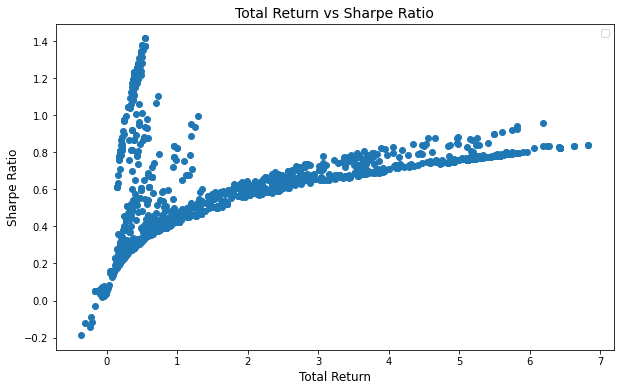

In [96]:
# Create a scatter plot for Total Return vs Sharpe Ratio
plt.figure(figsize=(10, 6))  # Increase the size of the plot

# Plot Total Return on the X-axis and Sharpe Ratio on the Y-axis
plt.scatter(a["total_return"], a["sharpe_ratio"])

# Label for the X-axis
plt.xlabel("Total Return", fontsize=12)  # Increase font size

# Label for the Y-axis
plt.ylabel("Sharpe Ratio", fontsize=12)  # Increase font size

# Title of the plot
plt.title("Total Return vs Sharpe Ratio", fontsize=14)  # Increase font size

plt.legend()  

# Show the plot
plt.show()

In [134]:
a["total_return"].vbt.heatmap().show()

## <span style="color:#FF5733">**<u>2. WFO for crackspread strategy</u>**</span>

In [97]:
# Definir parámetros y datos para la estrategia
window = 21
thresh = 2
refiner_symbol = "PSX"
start = pd.Timestamp("2010")
end = pd.Timestamp("2023-12-31")
data = vbt.YFData.download(
    ["CL=F", "RB=F", "HO=F", refiner_symbol], start=start, end=end, missing_index="drop"
)

cl = data.get("Close")["CL=F"]
rb = data.get("Close")["RB=F"]
ho = data.get("Close")["HO=F"]
refiner = data.get("Close")[refiner_symbol]

# Calcular el crack spread
rb *= 42
ho *= 42
crack_spread = (2 * rb + ho - 3 * cl) / 3

# Normalizar el crack spread y encontrar la divergencia entre el crack spread y el precio de las refinerías
crack_spread_rank = crack_spread.rolling(window).rank(pct=True)
refiner_rank = refiner.rolling(window).rank(pct=True)
rank_spread = refiner_rank - crack_spread_rank
roll = rank_spread.rolling(window)
zscore = (rank_spread - roll.mean()) / roll.std()
            

/Applications/anaconda3/lib/python3.8/site-packages/vectorbt/data/base.py:527: UserWarning: Symbols have mismatching index. Dropping missing data points.
  data = cls.align_index(data, missing=missing_index)


In [98]:
# Define rolling split
(in_price, in_indexes), (out_price, out_indexes) = zscore.vbt.rolling_split(
    n=30,
    window_len=365 * 2,
    set_lens=(180,),
    left_to_right=False,
    trace_names=["train", "test"],
)

(in_price_stock, in_indexes_stock), (out_price_stock, out_indexes_stock) = refiner.vbt.rolling_split(
    n=30,
    window_len=365 * 2,
    set_lens=(180,),
    left_to_right=False,
    trace_names=["train", "test"],
)

In [99]:
# Define rolling split for zscore
zscore.vbt.rolling_split(
    n=30,
    window_len=365 * 2,
    set_lens=(180,),
    left_to_right=False,
    trace_names=["train", "test"],
    plot=True,
)

FigureWidget({
    'data': [{'colorscale': [[0.0, '#1f77b4'], [1.0, '#1f77b4']],
              'hoverongaps': False,
              'name': 'train',
              'showlegend': True,
              'showscale': False,
              'type': 'heatmap',
              'uid': 'f38ebeee-fefb-4c4b-908f-6eb49abfc727',
              'x': array([datetime.datetime(2012, 4, 12, 4, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2012, 4, 13, 4, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2012, 4, 16, 4, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2023, 12, 27, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 12, 28, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 12, 29, 5, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17,

In [100]:
# Graph the rolling split for the refiner stock
refiner.vbt.rolling_split(
    n=30,
    window_len=365 * 2,
    set_lens=(180,),
    left_to_right=False,
    trace_names=["train", "test"],
    plot=True,
)

FigureWidget({
    'data': [{'colorscale': [[0.0, '#1f77b4'], [1.0, '#1f77b4']],
              'hoverongaps': False,
              'name': 'train',
              'showlegend': True,
              'showscale': False,
              'type': 'heatmap',
              'uid': 'a0ff8e65-3fdb-4906-a98a-3399aa8f8400',
              'x': array([datetime.datetime(2012, 4, 12, 4, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2012, 4, 13, 4, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2012, 4, 16, 4, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2023, 12, 27, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 12, 28, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 12, 29, 5, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17,

In [101]:
# Compare indexes from the rolling split
def compare_indexes(in_index, in_index_stock):
    # Check if the lists have the same length
    if len(in_index) != len(in_index_stock):
        print("The lists do not have the same length.")
        return False
    
    # Iterate through both indexes and compare each one
    for i, (idx1, idx2) in enumerate(zip(in_index, in_index_stock)):
        if not idx1.equals(idx2):
            print(f"The indexes do not match in DataFrame {i}")
            return False
    
    # Print if all indexes match
    print("All indexes match")
    return True

# Assuming in_index and in_index_stock are already defined variables
compare_indexes(in_indexes, in_indexes_stock)


All indexes match


True

## Simulate all threshold combinations

In [113]:

entry_th = np.arange(0.1, 3.6, 0.1)  # Entry thresholds
exit_th = np.arange(0.1, 3.6, 0.1)  # Exit thresholds

# Create all possible combinations of thresholds
threshold_combinations = list(product(entry_th, exit_th))

# Simulate all possible combinations of thresholds
def simulate_all_params(in_price, threshold_combinations): 
    """simulate all possible combinations of thresholds for the crackspread strategy
    
    This function tests all possible combinations of entry and exit thresholds for the crackspread strategy.
    
    Parameters: 
    ------------
    in_price: pd.Series
        Price windows for the training period
    threshold_combinations: list
        List of all possible combinations of entry and exit thresholds
        
    Returns:
    ------------
    in_stats: pd.DataFrame
        DataFrame containing the statistics for each combination of thresholds for each window
    """
    
    MyZScoreIndicator = IndicatorFactory(
    class_name="MyZScoreIndicator",
    input_names=["in_price"],
    param_names=["entry_th", "exit_th"],
    output_names=["entry_signal", "exit_signal"]   
    ).from_apply_func(
    
    lambda in_price, entry_th, exit_th: (
    
    in_price < -entry_th, 
    in_price > exit_th
        )
    )
    
    
    # Execute the indicator for all threshold combinations
    ind = MyZScoreIndicator.run(in_price, *zip(*threshold_combinations))

    entries = ind.entry_signal
    exits = ind.exit_signal
    clean_long_entries, clean_long_exits = entries.vbt.signals.clean(exits)
    
    pf = vbt.Portfolio.from_signals(
        close=in_price_stock,
        entries=clean_long_entries,
        exits=clean_long_exits,
        size=1.0,
        size_type="percent",
        init_cash=25_000,
        freq="1D",
    )
    
    in_sharpe_ratio = pf.sharpe_ratio()
    in_total_return = pf.total_return()
    in_max_drawdown = pf.max_drawdown()
    in_sortino_ratio = pf.sortino_ratio()
    
    in_parameters = pd.concat([in_sharpe_ratio, in_total_return, in_max_drawdown, in_sortino_ratio], axis=1)
    
    return in_parameters
            

In [114]:
in_stats = simulate_all_params(in_price, threshold_combinations)

In [116]:
in_stats

sharpe_ratio  \
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0              2.870428   
                                                     1              2.320276   
                                                     2              2.185794   
                                                     3              1.928232   
                                                     4              2.430364   
...                                                                      ...   
3.5                        3.5                       25                  inf   
                                                     26                  inf   
                                                     27                  inf   
                                                     28                  inf   
                                                     29                  inf   

                                                                total_return  \
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0              1.650814   
                                                     1              1.184156   
                                                     2              1.139684   
                                                     3              0.881209   
                                                     4              1.176165   
...                                                                      ...   
3.5                        3.5                       25             0.000000   
                                                     26             0.000000   
                                                     27             0.000000   
                                                     28             0.000000   
                                                     29             0.000000   

                                                                max_drawdown  \
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0             -0.136562   
                                                     1             -0.136562   
                                                     2             -0.156408   
                                                     3             -0.156408   
                                                     4             -0.156408   
...                                                                      ...   
3.5                        3.5                       25             0.000000   
                                                     26             0.000000   
                                                     27             0.000000   
                                                     28             0.000000   
                                                     29             0.000000   

                                                                sortino_ratio  
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0               4.936517  
                                                     1               3.762380  
                                                     2               3.444354  
                                                     3               2.954816  
                                                     4               3.910931  
...                                                                       ...  
3.5                        3.5                       25                   inf  
                                                     26                   inf  
                                                     27                   inf  
                                                     28      

## Get best Thresholds from the in price splits

In [120]:
def get_best_params(performance, level_name):
    """Get the best parameters based on total_return performance.

    This function retrieves the parameter values that
    maximize the total_return for each split.

    Parameters
    ----------
    performance : pd.DataFrame
        DataFrame containing performance metrics, including total_return
    level_name : str
        The level name to extract parameter values from

    Returns
    -------
    np.ndarray
        Array of best parameter values
    """

    idx = performance.groupby("split_idx")["total_return"].idxmax()
    return performance.loc[idx].index.get_level_values(level_name).to_numpy()


In [121]:
in_best_total_return_entry = get_best_params(in_stats, "myzscoreindicator_entry_th")

In [122]:
in_best_total_return_exit = get_best_params(in_stats, "myzscoreindicator_exit_th")

In [130]:
print(f"best exit thresholds: {in_best_total_return_exit}")
print()
print(f"best entry thresholds: {in_best_total_return_entry}")

best exit thresholds: [2.  1.8 0.8 0.8 0.8 0.8 0.8 1.4 0.8 1.6 1.6 1.7 2.2 2.2 2.2 2.2 2.4 2.4
 2.4 2.4 2.3 2.3 1.1 3.  2.7 2.7 2.7 2.7 2.7 2.9]

best entry thresholds: [1.3 0.2 0.1 0.1 0.1 0.1 0.1 1.1 0.1 0.8 1.3 1.8 2.  2.  0.6 2.7 2.7 2.7
 1.8 2.7 2.7 2.7 1.6 2.6 2.6 2.6 2.1 2.2 2.1 2.2]


In [132]:
in_best_th_pairs = np.array(list(zip(in_best_total_return_entry, in_best_total_return_exit)))

In [133]:
in_best_th_pairs

array([[1.3, 2. ],
       [0.2, 1.8],
       [0.1, 0.8],
       [0.1, 0.8],
       [0.1, 0.8],
       [0.1, 0.8],
       [0.1, 0.8],
       [1.1, 1.4],
       [0.1, 0.8],
       [0.8, 1.6],
       [1.3, 1.6],
       [1.8, 1.7],
       [2. , 2.2],
       [2. , 2.2],
       [0.6, 2.2],
       [2.7, 2.2],
       [2.7, 2.4],
       [2.7, 2.4],
       [1.8, 2.4],
       [2.7, 2.4],
       [2.7, 2.3],
       [2.7, 2.3],
       [1.6, 1.1],
       [2.6, 3. ],
       [2.6, 2.7],
       [2.6, 2.7],
       [2.1, 2.7],
       [2.2, 2.7],
       [2.1, 2.7],
       [2.2, 2.9]])

## Simulate every combination of windows for out sample data

In [137]:
def simulate_all_params_out(out_price, threshold_combinations): 
    
    from vectorbt.indicators import IndicatorFactory

    MyZScoreIndicator = IndicatorFactory(
    class_name="MyZScoreIndicator",
    input_names=["out_price"],
    param_names=["entry_th", "exit_th"],
    output_names=["entry_signal", "exit_signal"]   
    ).from_apply_func(
    
    lambda out_price, entry_th, exit_th: (
    
    out_price < -entry_th, 
    out_price > exit_th
        )
    )
    
    
    # Execute the indicator for all threshold combinations
    ind = MyZScoreIndicator.run(out_price, *zip(*threshold_combinations))

    entries = ind.entry_signal
    exits = ind.exit_signal
    clean_long_entries, clean_long_exits = entries.vbt.signals.clean(exits)
    
    pf = vbt.Portfolio.from_signals(
        close=out_price_stock,
        entries=clean_long_entries,
        exits=clean_long_exits,
        size=1.0,
        size_type="percent",
        init_cash=25_000,
        freq="1D",
    )
    
    out_sharpe_ratio = pf.sharpe_ratio()
    out_total_return = pf.total_return()
    out_max_drawdown = pf.max_drawdown()
    out_sortino_ratio = pf.sortino_ratio()
    
    out_parameters = pd.concat([out_sharpe_ratio, out_total_return, out_max_drawdown, out_sortino_ratio], axis=1)
    
    
    return out_parameters

In [139]:
out_stats = simulate_all_params_out(out_price, threshold_combinations)

In [140]:
out_stats

sharpe_ratio  \
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0              0.209044   
                                                     1              2.174474   
                                                     2              1.682774   
                                                     3             -0.218880   
                                                     4             -0.134977   
...                                                                      ...   
3.5                        3.5                       25                  inf   
                                                     26                  inf   
                                                     27                  inf   
                                                     28                  inf   
                                                     29                  inf   

                                                                total_return  \
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0              0.010614   
                                                     1              0.274507   
                                                     2              0.189128   
                                                     3             -0.042179   
                                                     4             -0.030452   
...                                                                      ...   
3.5                        3.5                       25             0.000000   
                                                     26             0.000000   
                                                     27             0.000000   
                                                     28             0.000000   
                                                     29             0.000000   

                                                                max_drawdown  \
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0             -0.156408   
                                                     1             -0.080168   
                                                     2             -0.144148   
                                                     3             -0.237282   
                                                     4             -0.265616   
...                                                                      ...   
3.5                        3.5                       25             0.000000   
                                                     26             0.000000   
                                                     27             0.000000   
                                                     28             0.000000   
                                                     29             0.000000   

                                                                sortino_ratio  
myzscoreindicator_entry_th myzscoreindicator_exit_th split_idx                 
0.1                        0.1                       0               0.301552  
                                                     1               3.504459  
                                                     2               2.501241  
                                                     3              -0.290936  
                                                     4              -0.183074  
...                                                                       ...  
3.5                        3.5                       25                   inf  
                                                     26                   inf  
                                                     27                   inf  
                                                     28      

## Simulate best pair of each training window into the out sample window

In [152]:
results = []
for i, column in enumerate(out_price.columns):
    window_price = out_price[column]  # Extract the price window for the current column (time series)
    entry_th = in_best_total_return_entry[i]  # Get the best entry threshold for the current window
    exit_th = in_best_total_return_exit[i]  # Get the best exit threshold for the current window
    window_stock_price = out_price_stock[column]  # Get the stock price for the current window
    
    # Generate entry and exit signals based on thresholds
    entries = window_price < -entry_th  
    exits = window_price > exit_th  
    clean_long_entries, clean_long_exits = entries.vbt.signals.clean(exits)  
    
    # Create a portfolio simulation from the generated signals
    pf = vbt.Portfolio.from_signals(
        close=window_stock_price,
        entries=clean_long_entries, 
        exits=clean_long_exits,
        size=1.0,  
        size_type="percent",
        init_cash=25_000, 
        freq="1D",  
    )
        
    results.append(pf.total_return())  # Append the total return of the portfolio for this window
        
# Store the results in a DataFrame with 'Total Return' as the column name
results_df = pd.DataFrame(results, columns=["Total Return"], index=out_price.columns)

    

In [156]:
results_df

,Total Return
split_idx,
0,-0.000407
1,0.247771
2,0.264416
3,0.178759
4,0.181218
5,0.163467
6,0.129353
7,0.061934
8,0.043620


# One-sided t test

In [173]:
# Calculate the median of in-sample 'total_return' for each split
in_sample_median = in_stats["total_return"].groupby("split_idx").median().values

# Extract out-sample test results from results_df
out_sample_test = results_df.values

# Print the length of both in-sample and out-sample arrays to check consistency
print(len(in_sample_median), len(out_sample_test))


30 30


In [174]:
t, p = stats.ttest_ind(a=out_sample_test, b=in_sample_median, alternative="greater")


In [175]:
t, p

(array([-1.29720026]), array([0.90015067]))